In [393]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn import neighbors
%matplotlib inline

## Scrape Data, Conduct General Cleaning

In [394]:
#Create list of teams

teams = ['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN',
       'CLE', 'COL', 'DET', 'FLA', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA',
       'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP',
       'SEA', 'SFG', 'STL', 'TBD', 'TBR', 'TEX', 'TOR', 'WSN']

In [395]:
#Create empty dataframe to append onto after each run
team_df = pd.DataFrame()

#Set our list of columns to be added at the end
columns_list = ['day', 'date', 'box_score', 'team', 'home_away', 'opponent', 'WL', 'runs', 'runs_against',
            'innings', 'record', 'division_rank', 'GB', 'winning_pitcher', 'losing_pitcher',
            'save_pitcher', 'time', 'day_night', 'attendance_1', 'attendance_2', 'streak', 'original', 'year_num']
    
#Make a pass for each team, for each year
for team in teams:
    for year in range(2016, 2018):
        try:
            html = requests.get('http://www.baseball-reference.com/teams/' + team + '/' + str(year) +
                                '-schedule-scores.shtml')
            bs = BeautifulSoup(html.text, 'html.parser')
            trows = bs.find('table', {'class':'stats_table'}).find_all('tr')
            results = []
            for trow in trows:
                cells = trow.find_all('td')
                str_cells = str(cells)
                cleantext = BeautifulSoup(str_cells, 'html.parser').get_text()
                results.append(cleantext + ',' + str(year))
            df = pd.DataFrame(results)
            team_df = team_df.append(df, ignore_index=True)

        except:
            pass
    
#Clean our final dataframe
team_df = team_df[0].str.split(',', expand=True) #split beautiful soup elements into each cell
team_df[0] = team_df[0].str.strip('[') #remove front bracket
team_df.iloc[:,-2] = team_df.iloc[:,-2].str.strip(']') #remove end backet
team_df.columns = columns_list #set out column names
team_df = team_df.iloc[1:] #remove first blank row
team_df = team_df.drop(['box_score', 'innings', 'original', 'save_pitcher'], 1) #drop unnecessary columns
team_df['attendance'] = team_df['attendance_1'].astype(str) + team_df['attendance_2'].astype(str) #concatenating attendance columns that were separated
team_df['attendance'] = pd.to_numeric(team_df['attendance'], errors='coerce') #convert new attendance column to int
team_df = team_df.drop(['attendance_1', 'attendance_2'], 1) #now drop unnecessary attendance columns after conversion
team_df['win'], team_df['loss'] = team_df['record'].str.split('-', 1).str #split record into win/loss (temporary)
team_df['win'] = pd.to_numeric(team_df['win'], errors='coerce') #convert win to int
team_df['loss'] = pd.to_numeric(team_df['loss'], errors='coerce') #convert loss to int
team_df['win_percentage'] = round(team_df['win']/(team_df['win'] + team_df['loss']), 2) #create win percentage column
team_df = team_df.drop(['win', 'loss', 'record'], 1) #now drop unnecessary win/loss/record after creating win percentage

#Get a feel for our dataframe
pd.options.display.max_columns = 30
print("Shape of Dataframe is {}".format(team_df.shape))
display(team_df.head(50))
print(team_df.dtypes)

Shape of Dataframe is (10535, 18)


,day,date,team,home_away,opponent,WL,runs,runs_against,division_rank,GB,winning_pitcher,losing_pitcher,time,day_night,streak,year_num,attendance,win_percentage
1,Monday,Apr 4,ARI,,COL,L,5,10,4,1.0,Miller,Greinke,4:11,N,-,2016,48165.0,0.00
2,Tuesday,Apr 5,ARI,,COL,W,11,6,3,1.0,Clippard,Bergman,3:14,N,+,2016,21830.0,0.50
3,Wednesday,Apr 6,ARI,,COL,L,3,4,4,2.0,Chatwood,Corbin,2:39,D,-,2016,18572.0,0.33
4,Thursday,Apr 7,ARI,,CHC,L,6,14,4,2.0,Lackey,De La Rosa,3:29,N,--,2016,24656.0,0.25
5,Friday,Apr 8,ARI,,CHC,W-wo,3,2,4,2.0,Ziegler,Cahill,2:48,N,+,2016,27539.0,0.40
6,Saturday,Apr 9,ARI,,CHC,L,2,4,5,2.0,Hendricks,Greinke,2:46,N,-,2016,32185.0,0.33
7,Sunday,Apr 10,ARI,,CHC,L,3,7,5,3.0,Arrieta,Miller,3:21,D,--,2016,33258.0,0.29
8,Tuesday,Apr 12,ARI,@,LAD,W,4,2,4,3.0,Clippard,Hatcher,3:00,D,+,2016,53279.0,0.38
9,Wednesday,Apr 13,ARI,@,LAD,L,1,3,4,3.0,Wood,De La Rosa,3:12,N,-,2016,44244.0,0.33
10,Thursday,Apr 14,ARI,@,LAD,L,2,5,4,3.0,Howell,Delgado,2:36,N,--,2016,40879.0,0.30


day                 object
date                object
team                object
home_away           object
opponent            object
WL                  object
runs                object
runs_against        object
division_rank       object
GB                  object
winning_pitcher     object
losing_pitcher      object
time                object
day_night           object
streak              object
year_num            object
attendance         float64
win_percentage     float64
dtype: object


## Further Data Cleaning, Preliminary Feature Engineering

In [396]:
#Remove white space
for col in team_df.columns:
    team_df[col] = team_df[col].astype(str)
    team_df[col] = team_df[col].str.strip()

In [397]:
#Filter out away games
team_df = team_df.loc[team_df['home_away'] == '']

In [398]:
#Recreate WL groupings
team_df['WL'].replace(['L', 'W', 'W-wo', 'L-wo', 'None', 'T', 'W &H;', 'W &V;', 'L &V;', 'L &H;'],
                      ['L', 'W', 'W', 'L', 'None', 'T', 'W', 'W', 'L', 'L'], inplace=True)

In [399]:
#Remove None from WL
team_df = team_df.loc[team_df['WL'] != 'None']

In [400]:
#Turn day_night into indicator (day = 1, night = 0)
team_df['day_night'] = np.where((team_df['day_night'] == 'D'), 1, 0)

In [401]:
#Understand unique streak values
team_df.streak.unique()

array(['-', '+', '--', '---', '----', '-----', '++', '+++', '------',
       '++++', '+++++', '++++++', '+++++++', '-------', '++++++++',
       '+++++++++', '++++++++++', '+++++++++++', ']', '--------',
       '---------', '++++++++++++++++', '+++++++++++++++++',
       '++++++++++++++++++', '+++++++++++++++++++',
       '++++++++++++++++++++', '+++++++++++++++++++++',
       '++++++++++++++++++++++', '-----------', '----------'],
      dtype=object)

In [402]:
#Streak function

def streak(x):
    x_streak = str(x)
    x_streak = list(x_streak)
    counter = 0
    if x_streak[0] == '-':
        for i in x_streak:
            counter += 1
            final = '-' + str(counter)
            final = int(final)
    else:
        for i in x_streak:
            counter += 1
            final = '+' + str(counter)
            final = int(final)
    return final

In [403]:
#Apply streak function to streak column
team_df['streak'] = team_df['streak'].apply(streak)

In [404]:
#Confirm this worked
team_df['streak'].head(5)

1   -1
2    1
3   -1
4   -2
5    1
Name: streak, dtype: int64

In [405]:
#Deal with GB column
team_df['GB'].unique()

array(['1.0', '2.0', '3.0', '1.5', '2.5', '0.5', '4.0', '5.0', '4.5',
       '5.5', '9.0', '10.0', '10.5', '9.5', '11.5', '12.5', '13.5',
       '15.0', '14.0', '16.0', '19.0', '18.0', '17.0', '18.5', '17.5',
       '21.0', '22.0', '20.0', '24.0', '23.0', 'up 0.5', 'Tied', 'up 1.0',
       '3.5', '6.5', '7.5', '6.0', '7.0', '8.0', '12.0', '16.5', '19.5',
       '20.5', '21.5', '23.5', '24.5', '25.0', '25.5', '26.5', '27.5',
       '28.5', '29.5', '28.0', '29.0', '30.0', '31.0', '32.0', '11.0',
       '14.5', '22.5', 'up 1.5', 'up 2.0', 'up 2.5', 'up 3.5', 'up 3.0',
       'up 4.0', '8.5', '15.5', 'up 5.0', 'up 4.5', 'up 6.5', 'up 7.5',
       'up 8.5', 'up 7.0', 'up 8.0', 'up 9.0', 'up 5.5', 'up 9.5',
       'up10.5', 'up11.5', 'up12.5', 'up12.0', 'up13.0', 'up14.0',
       'up15.0', 'up15.5', 'up16.5', 'up17.0', 'up18.0', 'up16.0', '13.0',
       '30.5', '33.5', '34.5', '34.0', '26.0', '27.0', '31.5', '35.5',
       'up 6.0', 'up11.0', 'up13.5', 'up14.5', '33.0', '35.0', '36.0',
     

In [406]:
#Create function to convert GB

def gb(x):
    x = x.replace(" ", "")
    if x[0] == 'u':
        x = x[2:]
        x = float(x)

    elif x[0].isdigit() == True:
        x = '-' + x
        x = float(x)
    
    else:
        x = 0
        
    return x

In [407]:
#Apply function to GB column
team_df['GB'] = team_df['GB'].apply(gb)

In [408]:
#Clean date column, first create function
import re
def remove_parentheses(i):
    i = str(i)
    i = re.sub(r'\([^)]*\)', '', i)
    return i

In [409]:
#Apply it to date column
team_df['date'] = team_df['date'].apply(remove_parentheses)

In [410]:
#Strip whitespace again after removing parentheses data
team_df['date'] = team_df['date'].str.strip()

In [411]:
#Convert date into month and day
team_df['month_num'], team_df['day_num'] = team_df['date'].str.split(' ', 1).str

In [412]:
#Recreate month_num groupings
team_df['month_num'].replace(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'],
                      [4, 5, 6, 7, 8, 9, 10], inplace=True)

In [413]:
#Deal with null values
missing_values_count = team_df.isnull().sum()
print(missing_values_count)

day                0
date               0
team               0
home_away          0
opponent           0
WL                 0
runs               0
runs_against       0
division_rank      0
GB                 0
winning_pitcher    0
losing_pitcher     0
time               0
day_night          0
streak             0
year_num           0
attendance         0
win_percentage     0
month_num          0
day_num            0
dtype: int64


In [414]:
#Do pd.datetime on all date related columns
team_df = team_df.loc[team_df['year_num'] != 'None']

team_df['month_num'] = team_df['month_num'].astype(int)
team_df['day_num'] = team_df['day_num'].astype(int)
team_df['year_num'] = team_df['year_num'].astype(int)

In [415]:
#Create standardized date column
team_df['actual_date'] = pd.to_datetime(team_df.year_num*10000+team_df.month_num*100+team_df.day_num,format='%Y%m%d')

In [416]:
#Final removal of columns - date, home_away
team_df = team_df.drop(['date', 'home_away'], 1)

In [417]:
#Convert time of game column - first create function

def convert_game_time(x):
    x = str(x)
    i, j = x.split(':')
    i, j = int(i), int(j)
    x = (i*60) + (j)
    return x

In [418]:
#Apply function to time column
team_df['time'] = team_df['time'].apply(convert_game_time)

In [419]:
#Convert all data types to appropriate ones - first take a look at our datatypes
team_df.dtypes

day                        object
team                       object
opponent                   object
WL                         object
runs                       object
runs_against               object
division_rank              object
GB                        float64
winning_pitcher            object
losing_pitcher             object
time                        int64
day_night                   int64
streak                      int64
year_num                    int64
attendance                 object
win_percentage             object
month_num                   int64
day_num                     int64
actual_date        datetime64[ns]
dtype: object

In [420]:
#Apply conversions
team_df['win_percentage'] = team_df['win_percentage'].astype(float)
team_df['attendance'] = team_df['attendance'].astype(float)
team_df['division_rank'] = team_df['division_rank'].astype(float)
team_df['GB'] = team_df['GB'].astype(float)
team_df['runs'] = team_df['runs'].astype(int)
team_df['runs_against'] = team_df['runs_against'].astype(int)

#Label encoders for categoricals
encoder = LabelEncoder()
team_df['day_category'] = encoder.fit_transform(team_df['day'])
team_df['team_category'] = encoder.fit_transform(team_df['team'])
team_df['opponent_category'] = encoder.fit_transform(team_df['opponent'])
team_df['WL_category'] = encoder.fit_transform(team_df['WL'])

In [421]:
#Add ticket price data
ticket_prices = pd.read_csv('ticket_prices.csv')

In [422]:
ticket_prices.head(10)

,team,year_num,price
0,ATL,2017,80
1,CHC,2017,130
2,STL,2017,75
3,TBD,2017,89
4,NYY,2017,117
5,LAD,2017,64
6,MIL,2017,66
7,CIN,2017,80
8,PHI,2017,60
9,HOU,2017,73


In [423]:
#Merge our dataframes (prices and team_df)

team_df = pd.merge(team_df, ticket_prices, how='inner', on=['team', 'year_num'])

## Time Series Modeling

In [424]:
time_series_df = team_df.loc[:, ['attendance', 'actual_date']]

In [427]:
time_series_df.head()

,attendance,actual_date
0,48165.0,2016-04-04
1,21830.0,2016-04-05
2,18572.0,2016-04-06
3,24656.0,2016-04-07
4,27539.0,2016-04-08


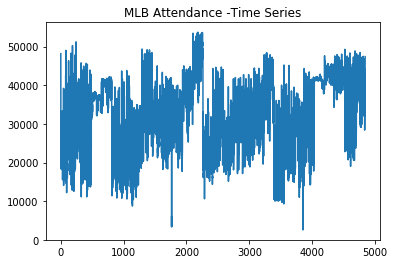

In [428]:
time_series_df.attendance.plot()
plt.title('MLB Attendance -Time Series')
plt.show()

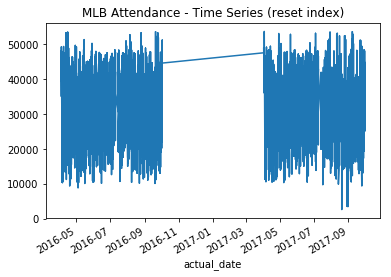

In [429]:
time_series_df.index = pd.to_datetime(time_series_df.actual_date)
time_series_df.attendance.plot()
plt.title('MLB Attendance - Time Series (reset index)')
plt.show()

Text(0.5,1,'MLB Attendance PACF')

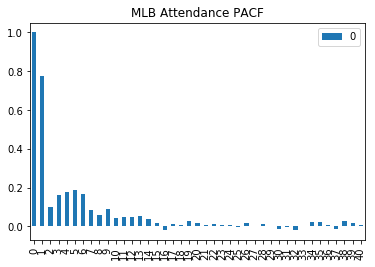

In [431]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(time_series_df.attendance))
x_acf.plot(kind='bar')
plt.title("MLB Attendance PACF")

## Building Models

In [434]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(time_series_df.attendance, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                 4845
Model:                     ARMA(1, 0)   Log Likelihood              -49012.500
Method:                       css-mle   S.D. of innovations           5985.320
Date:                Wed, 01 Aug 2018   AIC                          98031.000
Time:                        15:14:36   BIC                          98050.457
Sample:                    04-04-2016   HQIC                         98037.830
                         - 09-24-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.112e+04    385.215     80.796      0.000    3.04e+04    3.19e+04
ar.L1.attendance     0.7769      0.009     85.824      0.000       0.759       0.795
                            

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [438]:
from statsmodels.tsa.arima_model import ARIMA
model_101= ARIMA(time_series_df.attendance, order=(1,0,1))
model_101_fit = model_101.fit(disp=0)
print(model_101_fit.summary())
print('Residuals Description')
print(model_101_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                 4845
Model:                     ARMA(1, 1)   Log Likelihood              -48961.024
Method:                       css-mle   S.D. of innovations           5922.010
Date:                Wed, 01 Aug 2018   AIC                          97930.049
Time:                        15:21:51   BIC                          97955.991
Sample:                    04-04-2016   HQIC                         97939.156
                         - 09-24-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.112e+04    531.615     58.546      0.000    3.01e+04    3.22e+04
ar.L1.attendance     0.8921      0.013     66.967      0.000       0.866       0.918
ma.L1.attendance    -0.3247 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [437]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(time_series_df.attendance, order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:           D.attendance   No. Observations:                 4844
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -48623.286
Method:                       css-mle   S.D. of innovations           5534.673
Date:                Wed, 01 Aug 2018   AIC                          97270.572
Time:                        15:15:35   BIC                          97348.398
Sample:                    04-05-2016   HQIC                         97297.893
                         - 09-24-2017                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3947     14.213      0.168      0.866     -25.462      30.252
ar.L1.D.attendance    -0.0744      0.288     -0.258      0.796      -0.639       0.490
ar.L2.D.attendance  

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


## Residuals

Text(0.5,1,'Histogram of Residuals')

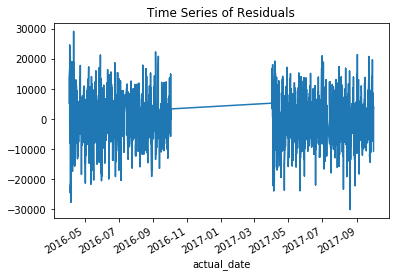

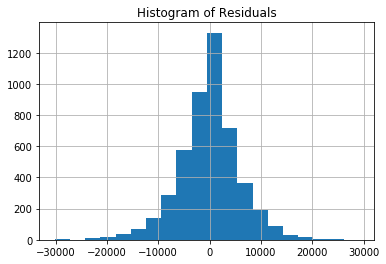

In [439]:
residuals = pd.DataFrame(model_101_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

## Evaluating our Time Series Model

Model_515 recorded the lowest AIC score at approximately 97270. In comparison, Model_101 recorded an AIC of 97930 and model_100 roughly 98000.